In [1]:
!pip install mip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.8/441.8 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygit2 1.16.0 requires cffi>=1.17.0, but you have cffi 1.15.1 which is incompatible.


In [2]:
import mip
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

Parámetros del modelo

In [5]:

# Definición de los datos del problema
Location = namedtuple("Location", ["x", "y"])
Customer = namedtuple("Customer", ["index", "location", "demand", "time_window"])

# Parámetros del problema
num_vehicles = 2
#vehicle_capacities = [20, 40, 20]  # Capacidad distinta para cada vehículo
vehicle_capacities = [40,40]  # Capacidad distinta para cada vehículo
depot = Customer(index=0, location=Location(50, 50), demand=0, time_window=(0, 1000))

# Lista de clientes con demandas y ventanas de tiempo
"""
customers = [
    Customer(index=1, location=Location(30, 40), demand=4, time_window=(10, 200)),
    Customer(index=2, location=Location(40, 30), demand=5, time_window=(30, 400)),
    Customer(index=3, location=Location(60, 80), demand=6, time_window=(50, 500)),
    Customer(index=4, location=Location(70, 60), demand=3, time_window=(70, 600)),
    Customer(index=5, location=Location(30, 20), demand=7, time_window=(90, 700)),
    Customer(index=6, location=Location(20, 50), demand=8, time_window=(100, 500)),
    Customer(index=7, location=Location(60, 60), demand=4, time_window=(110, 300)),
    Customer(index=8, location=Location(80, 70), demand=5, time_window=(200, 600)),
    Customer(index=9, location=Location(55, 25), demand=3, time_window=(250, 700)),
    Customer(index=10, location=Location(65, 15), demand=6, time_window=(300, 800)),
]
"""


customers = [
    Customer(index=1, location=Location(30, 40), demand=4, time_window=(10, 400)),
    Customer(index=2, location=Location(40, 30), demand=5, time_window=(30, 400)),
    Customer(index=3, location=Location(60, 80), demand=6, time_window=(50, 500)),
    Customer(index=4, location=Location(70, 60), demand=3, time_window=(70, 600)),
    Customer(index=5, location=Location(30, 20), demand=7, time_window=(90, 700)),
    Customer(index=6, location=Location(20, 50), demand=8, time_window=(100, 500)),
    Customer(index=7, location=Location(60, 60), demand=4, time_window=(110, 300)),
    Customer(index=8, location=Location(80, 70), demand=5, time_window=(200, 600)),
    Customer(index=9, location=Location(55, 25), demand=3, time_window=(250, 700)),
    Customer(index=10, location=Location(65, 15), demand=6, time_window=(300, 800)),
]

# Crear lista de todos los clientes, incluyendo el depósito
all_customers = [depot] + customers
num_customers = len(all_customers)

# Calcular la distancia euclidiana entre todos los clientes
distance_matrix = np.array([
    [np.hypot(c1.location.x - c2.location.x, c1.location.y - c2.location.y) for c2 in all_customers]
    for c1 in all_customers
])


In [6]:
# Crear el modelo
model = mip.Model()
# Variables de decisión
x = [[[model.add_var(var_type=mip.BINARY) for j in range(num_customers)] for i in range(num_customers)] for k in range(num_vehicles)]
u = [[model.add_var(var_type=mip.CONTINUOUS, lb=0) for i in range(num_customers)] for k in range(num_vehicles)]
t = [[model.add_var(var_type=mip.CONTINUOUS) for i in range(num_customers)] for k in range(num_vehicles)]

# Función objetivo: Minimizar la distancia total recorrida
model.objective = mip.minimize(
    mip.xsum( distance_matrix[i][j] * x[k][i][j] for k in range(num_vehicles) for i in range(num_customers) for j in range(num_customers))
)

# Restricciones
# 1. Cada cliente es visitado exactamente una vez
for j in range(1, num_customers):
  model += mip.xsum(x[k][i][j] for k in range(num_vehicles) for i in range(num_customers) if i != j) == 1

# 2. Los vehículos salen del depósito y regresan al depósito
for k in range(num_vehicles):
  model += mip.xsum(x[k][0][j] for j in range(1, num_customers)) == 1
  # Sale del depósito
  model += mip.xsum(x[k][i][0] for i in range(1, num_customers)) == 1
  # Regresa al depósito

# 3. Flujo de vehículos: cada cliente al que se llega también se deja
for k in range(num_vehicles):
  for i in range(1, num_customers):
    model += mip.xsum(x[k][i][j] for j in range(num_customers) if i != j) == mip.xsum(x[k][j][i] for j in range(num_customers) if i != j)


# 4. Restricción de capacidad del vehículo
for k in range(num_vehicles):
  for i in range(1, num_customers):
    for j in range(1, num_customers):
      if i != j:
        model += u[k][i] + customers[j - 1].demand * x[k][i][j] <= vehicle_capacities[k] + (1 - x[k][i][j]) * vehicle_capacities[k]


# 5. Restricción de ventanas de tiempo
for k in range(num_vehicles):
  for i in range(num_customers):
    for j in range(1, num_customers):
      if i != j:
        model += t[k][i] + distance_matrix[i][j] * x[k][i][j] <= t[k][j] + (1 - x[k][i][j]) * 10000


# 6. Restricción de cumplimiento de ventana de tiempo de cada cliente
for k in range(num_vehicles):
  for i in range(num_customers):
    for j in range(1, num_customers):
      if i != j:
        start_time, end_time = all_customers[j].time_window
        model += t[k][j] >= start_time * mip.xsum(x[k][i][j] for i in range(num_customers) if i != j)
        model += t[k][j] <= end_time * mip.xsum(x[k][i][j] for i in range(num_customers) if i != j)

In [7]:
# Resolver el modelo
model.optimize()
# Extraer y mostrar las rutas de cada vehículo
vehicle_routes = [[] for _ in range(num_vehicles)]

for k in range(num_vehicles):
  current_location = 0 # Comienza en el depósito

  while True:
    for j in range(num_customers):
      if x[k][current_location][j].x >= 0.99:
        vehicle_routes[k].append((current_location, j))
        current_location = j
        break
    if current_location == 0:
      break # Termina cuando el vehículo regresa al depósito


# Imprimir las rutas en pantalla y graficar
for k, route in enumerate(vehicle_routes):
  print(f"Ruta del vehículo {k + 1} (Capacidad {vehicle_capacities[k]}):")
  route_path = " -> ".join(str(start) for start, end in route)
  print(f"{route_path} -> 0") # Ruta completa de ida y vuelta

Ruta del vehículo 1 (Capacidad 40):
0 -> 3 -> 8 -> 4 -> 7 -> 0
Ruta del vehículo 2 (Capacidad 40):
0 -> 10 -> 9 -> 2 -> 5 -> 1 -> 6 -> 0


In [8]:
def verificar_solucion(vehicle_routes, all_customers, vehicle_capacities, distance_matrix, time_windows):
    # 1. Verificar que cada cliente sea visitado exactamente una vez
    visitados = set()
    for k, route in enumerate(vehicle_routes):
        for start, end in route:
            if end != 0:  # Ignorar el depósito
                if end in visitados:
                    print(f"Error: Cliente {end} es visitado más de una vez.")
                    return False
                visitados.add(end)

    if len(visitados) != len(all_customers) - 1:
        print("Error: No se han visitado todos los clientes exactamente una vez.")
        return False
    print("Restricción 1 cumplida: Cada cliente es visitado exactamente una vez.")

    # 2. Verificar que cada vehículo no exceda su capacidad
    for k, route in enumerate(vehicle_routes):
        carga_total = 0
        for start, end in route:
            carga_total += all_customers[end].demand
        if carga_total > vehicle_capacities[k]:
            print(f"Error: El vehículo {k + 1} excede su capacidad.")
            return False
    print("Restricción 2 cumplida: La capacidad de cada vehículo no es excedida.")

    # 3. Verificar que se cumplen las ventanas de tiempo de cada cliente
    for k, route in enumerate(vehicle_routes):
        tiempo_actual = 0
        for start, end in route:
            # Actualizar el tiempo actual con la distancia desde el último nodo
            tiempo_actual += distance_matrix[start][end]
            start_time, end_time = all_customers[end].time_window
            if tiempo_actual < start_time:
                tiempo_actual = start_time  # Esperar hasta que la ventana de tiempo abra
            if not (start_time <= tiempo_actual <= end_time):
                print(f"Error: El vehículo {k + 1} no cumple la ventana de tiempo para el cliente {end}.")
                return False
    print("Restricción 3 cumplida: Las ventanas de tiempo de cada cliente son respetadas.")

    # 4. Verificar que cada vehículo comienza y termina en el depósito
    for k, route in enumerate(vehicle_routes):
        if route[0][0] != 0 or route[-1][1] != 0:
            print(f"Error: El vehículo {k + 1} no comienza y/o termina en el depósito.")
            return False
    print("Restricción 4 cumplida: Cada vehículo comienza y termina en el depósito.")

    print("Todas las restricciones han sido cumplidas correctamente.")
    return True

# Llamada a la función de verificación
verificar_solucion(vehicle_routes, all_customers, vehicle_capacities, distance_matrix, [c.time_window for c in all_customers])

Restricción 1 cumplida: Cada cliente es visitado exactamente una vez.
Restricción 2 cumplida: La capacidad de cada vehículo no es excedida.
Restricción 3 cumplida: Las ventanas de tiempo de cada cliente son respetadas.
Restricción 4 cumplida: Cada vehículo comienza y termina en el depósito.
Todas las restricciones han sido cumplidas correctamente.


True

Graficar rutas

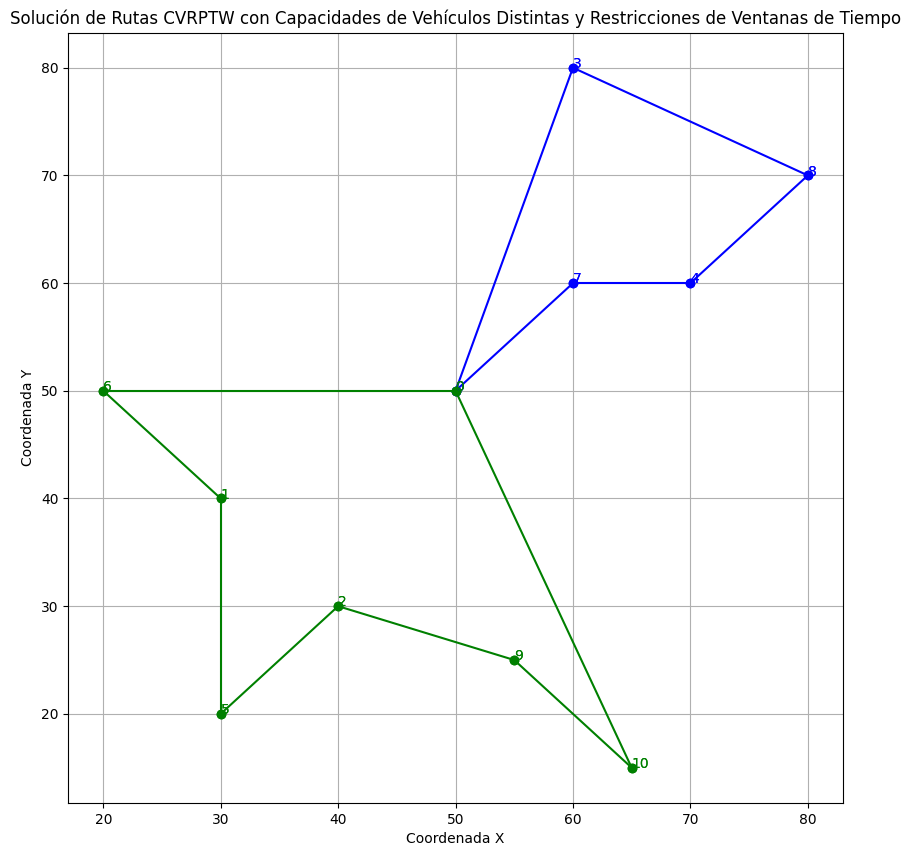

In [9]:
colors = ['b', 'g', 'r']

# Visualización de las rutas
plt.figure(figsize=(10, 10))

for k, route in enumerate(vehicle_routes):
  for start, end in route:
    plt.plot([all_customers[start].location.x, all_customers[end].location.x],
            [all_customers[start].location.y, all_customers[end].location.y], 'o-', color=colors[k])
    plt.text(all_customers[start].location.x, all_customers[start].location.y, f"{start}", color=colors[k])
    plt.text(all_customers[end].location.x, all_customers[end].location.y, f"{end}", color=colors[k])

plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Solución de Rutas CVRPTW con Capacidades de Vehículos Distintas y Restricciones de Ventanas de Tiempo")
plt.grid()
plt.show()

In [10]:
data = {}
data['Cliente'] = []
data['Vehiculo'] = []
data['VentanaInicio'] = []
data['VentanaFin'] = []
data['Llegada'] = []

for k in range(num_vehicles):
  for j in range(1,num_customers):
    if t[k][j].x > 0.0:
      data['Cliente'].append(str(j))
      data['Vehiculo'].append(str(k))
      data['VentanaInicio'].append( float(customers[j-1].time_window[0]) )
      data['VentanaFin'].append( float(customers[j-1].time_window[1]) )
      data['Llegada'].append(t[k][j].x)

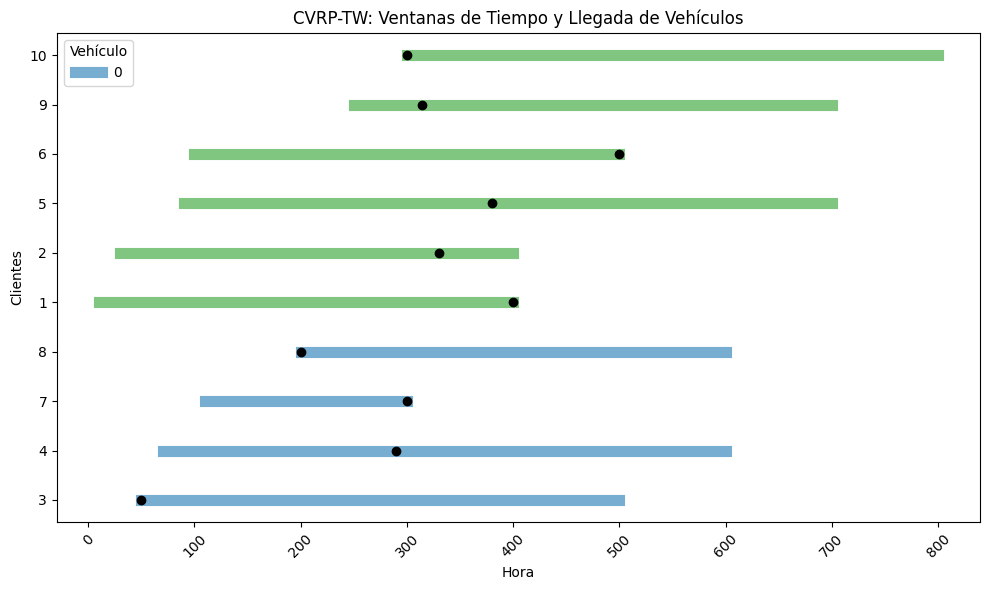

In [11]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

vehiculo_colors = {'0': 'tab:blue', '1': 'tab:green', '2': 'tab:red'}


for i, row in df.iterrows():
    ax.plot([row['VentanaInicio'], row['VentanaFin']], [i, i],
            color=vehiculo_colors[row['Vehiculo']], lw=8, alpha=0.6,
            label=row['Vehiculo'] if i == 0 else "")

    ax.plot(row['Llegada'], i, 'o', color='black')

ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['Cliente'])

plt.xticks(rotation=45)
plt.xlabel('Hora')
plt.ylabel('Clientes')
plt.title('CVRP-TW: Ventanas de Tiempo y Llegada de Vehículos')

ax.legend(title='Vehículo')
plt.tight_layout()
plt.show()

## Ahora intentamos generar el modelo de mezcla de Gaussianas para aprender la incertidumbre en las ventanas de tiempo

In [ ]:
import sklearn as sk